In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [89]:
dataset = tfds.load("imdb_reviews")

In [377]:
dataset_train = dataset["train"].shuffle(buffer_size = 4000)
dataset_test_val = dataset["test"].shuffle(buffer_size = 4000)
dataset_test = dataset_test_val.take(10000)
dataset_val  = dataset_test_val.skip(10000)

In [378]:
import tensorflow.keras as keras
dataset_texts = []

for sample in dataset_train.batch(32):
    dataset_texts.extend(sample["text"])

In [379]:
vectorization_layer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=10000, output_sequence_length=800)
vectorization_layer.adapt(dataset_texts)

In [380]:
def process_dataset(dataset, training = False):
    dataset = dataset.map(lambda x : (vectorization_layer([x["text"]])[0], x["label"]), num_parallel_calls = 8)
    if training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(10000)
    dataset = dataset.batch(32, drop_remainder = True)
    if not training:
        dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

dataset_train = process_dataset(dataset_train, True)
dataset_val = process_dataset(dataset_val)
dataset_test = process_dataset(dataset_test)

In [381]:
class MaskingLayer(keras.layers.Layer):
    
    def call(self, inp, mask):
        
        N = tf.reduce_sum(tf.cast(mask, tf.float32))
        sN = tf.math.sqrt(N)
                
        mean_embed = tf.reduce_sum(inp, axis=-2, keepdims=False)/sN
        return mean_embed        

In [421]:
input_layer = keras.layers.Input(shape=[800], dtype=tf.int64)
embedding_layer = keras.layers.Embedding(input_dim = 10000, output_dim = 120, mask_zero=True)(input_layer)
masking_layer = MaskingLayer()(embedding_layer)
entry = masking_layer#keras.layers.BatchNormalization(name = "batch")(embedding_layer)
wide = entry
deep = entry
for i in range(2):
    wide = keras.layers.Dense(400, activation="relu", kernel_regularizer = keras.regularizers.l2(0.01))(wide)
    wide = keras.layers.BatchNormalization()(wide)
    
for i in range(5):
    deep = keras.layers.Dense(50, activation="relu", kernel_regularizer = keras.regularizers.l2(0.01))(deep)
    deep = keras.layers.BatchNormalization()(deep)
    
concat = keras.layers.Concatenate()([wide, deep])
out = keras.layers.Dense(1, activation="sigmoid", kernel_regularizer = keras.regularizers.l2(0.01))(concat)

model = keras.models.Model(inputs=input_layer, outputs=out)

In [422]:
model.save_weights("movie_initial_weights", save_format="tf")

In [423]:
import numpy as np

In [424]:
learning_rates = np.logspace(-10, -1, 25)
losses = []

In [425]:
for learning_rate in learning_rates:
    model.compile(
        loss="binary_crossentropy",
        metrics=["accuracy"],
        optimizer = keras.optimizers.Nadam(learning_rate = learning_rate)
    )
    model.load_weights("movie_initial_weights")
    
    history = model.fit(dataset_train).history
    loss = history["loss"]
    losses.append(loss)

781/781 [==============================] - 12s 12ms/step - loss: 3.5504 - accuracy: 0.7244


In [426]:
import matplotlib.pyplot as plt

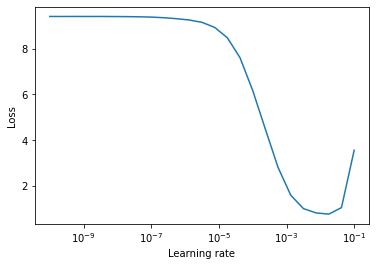

In [427]:
plt.plot(learning_rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.xscale("log")
plt.show()

In [428]:
final_lr = learning_rates[np.argmin(losses)]
print(final_lr)

0.01778279410038923


In [429]:
model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer = keras.optimizers.Nadam(learning_rate = final_lr)
)
model.load_weights("movie_initial_weights")

In [430]:
model.fit(dataset_train, validation_data=dataset_val, epochs = 300,
         callbacks=[keras.callbacks.EarlyStopping(patience = 20, restore_best_weights=True)])

Epoch 1/300
781/781 [==============================] - 14s 15ms/step - loss: 0.7421 - accuracy: 0.8113 - val_loss: 1.1745 - val_accuracy: 0.6335
Epoch 2/300
781/781 [==============================] - 11s 14ms/step - loss: 0.3305 - accuracy: 0.8836 - val_loss: 0.5943 - val_accuracy: 0.6965
Epoch 3/300
781/781 [==============================] - 11s 14ms/step - loss: 0.2968 - accuracy: 0.8994 - val_loss: 0.3795 - val_accuracy: 0.8540
Epoch 4/300
781/781 [==============================] - 11s 14ms/step - loss: 0.2453 - accuracy: 0.9107 - val_loss: 0.3723 - val_accuracy: 0.8498
Epoch 5/300
781/781 [==============================] - 11s 14ms/step - loss: 0.2548 - accuracy: 0.9145 - val_loss: 1.8190 - val_accuracy: 0.6259
Epoch 6/300
781/781 [==============================] - 11s 14ms/step - loss: 0.2278 - accuracy: 0.9211 - val_loss: 9.5514 - val_accuracy: 0.5123
Epoch 7/300
781/781 [==============================] - 11s 14ms/step - loss: 0.2340 - accuracy: 0.9224 - val_loss: 0.6178 - val_ac

In [432]:
model.evaluate(dataset_val)

468/468 [==============================] - 1s 3ms/step - loss: 0.3723 - accuracy: 0.8498


[0.37229472398757935, 0.8497596383094788]

85% accuracy on the validation set seems convincing, but the model could be regularized even more, since the test accuracy is ~95%. I will automate the process.

In [433]:
def build_model(reg_str):
    input_layer = keras.layers.Input(shape=[800], dtype=tf.int64)
    embedding_layer = keras.layers.Embedding(input_dim = 10000, output_dim = 120, mask_zero=True)(input_layer)
    masking_layer = MaskingLayer()(embedding_layer)
    entry = masking_layer#keras.layers.BatchNormalization(name = "batch")(embedding_layer)
    wide = entry
    deep = entry
    for i in range(2):
        wide = keras.layers.Dense(400, activation="relu", kernel_regularizer = keras.regularizers.l2(reg_str))(wide)
        wide = keras.layers.BatchNormalization()(wide)

    for i in range(5):
        deep = keras.layers.Dense(50, activation="relu", kernel_regularizer = keras.regularizers.l2(reg_str))(deep)
        deep = keras.layers.BatchNormalization()(deep)

    concat = keras.layers.Concatenate()([wide, deep])
    out = keras.layers.Dense(1, activation="sigmoid", kernel_regularizer = keras.regularizers.l2(reg_str))(concat)

    model = keras.models.Model(inputs=input_layer, outputs=out)
    
    return model

In [434]:
reg_strengths = np.logspace(-2, 4, 10)

In [439]:
for r in reg_strengths:
    learning_rates = np.logspace(-6, -1, 10)
    losses = []
    
    model = build_model(r)
    
    for learning_rate in learning_rates:
        model.compile(
            loss="binary_crossentropy",
            metrics=["accuracy"],
            optimizer = keras.optimizers.Nadam(learning_rate = learning_rate)
        )
        model.load_weights("movie_initial_weights")

        history = model.fit(dataset_train, verbose = 0).history
        loss = history["loss"]
        losses.append(loss)
        
    final_lr = learning_rates[np.argmin(losses)]
    
    model.fit(dataset_train, validation_data=dataset_val, epochs = 300, verbose = 0,
        callbacks=[keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)])
    
    val_acc = model.evaluate(dataset_val, verbose = 0)[1]
    
    print("Regularization coeff: {}, optimal lr: {}".format(r, final_lr))
    print("\tResult val acc:", val_acc)
    

Regularization coeff: 0.01, optimal lr: 0.007742636826811277
	Result val acc: 0.7930688858032227
Regularization coeff: 0.046415888336127774, optimal lr: 0.007742636826811277
	Result val acc: 0.7397168874740601
Regularization coeff: 0.21544346900318834, optimal lr: 0.007742636826811277
	Result val acc: 0.7672275900840759
Regularization coeff: 1.0, optimal lr: 0.007742636826811277
	Result val acc: 0.8432825803756714
Regularization coeff: 4.6415888336127775, optimal lr: 0.007742636826811277
	Result val acc: 0.4971287250518799
Regularization coeff: 21.54434690031882, optimal lr: 0.007742636826811277
	Result val acc: 0.5052083134651184
Regularization coeff: 100.0, optimal lr: 0.007742636826811277
	Result val acc: 0.503004789352417
Regularization coeff: 464.1588833612773, optimal lr: 0.007742636826811277
	Result val acc: 0.48965010046958923
Regularization coeff: 2154.4346900318824, optimal lr: 0.007742636826811277
	Result val acc: 0.4993322789669037
Regularization coeff: 10000.0, optimal lr:

The most optimal regularization coefficient seems to lie around 1.0. 

In [440]:
reg_strengths = np.linspace(0.2, 3, 20)

In [472]:
for r in reg_strengths:
    learning_rates = np.logspace(-6, -1, 10)
    losses = []
    
    model = build_model(r)
    
    for learning_rate in learning_rates:
        model.compile(
            loss="binary_crossentropy",
            metrics=["accuracy"],
            optimizer = keras.optimizers.Nadam(learning_rate = learning_rate)
        )
        model.load_weights("movie_initial_weights")

        history = model.fit(dataset_train, verbose = 0).history
        loss = history["loss"]
        losses.append(loss)
        
    final_lr = learning_rates[np.argmin(losses)]
    
    model.load_weights("movie_initial_weights")
    
    model.fit(dataset_train, validation_data=dataset_val, epochs = 300, verbose = 0,
        callbacks=[keras.callbacks.EarlyStopping(patience = 25, restore_best_weights=True)])
    
    val_acc = model.evaluate(dataset_val, verbose = 0)[1]
    
    print("Regularization coeff: {}, optimal lr: {}".format(r, final_lr))
    print("\tResult val acc:", val_acc)
    

Regularization coeff: 0.2, optimal lr: 0.007742636826811277
	Result val acc: 0.7506677508354187
Regularization coeff: 0.34736842105263155, optimal lr: 0.007742636826811277
	Result val acc: 0.7387820482254028
Regularization coeff: 0.49473684210526314, optimal lr: 0.007742636826811277
	Result val acc: 0.8418135643005371
Regularization coeff: 0.6421052631578947, optimal lr: 0.007742636826811277
	Result val acc: 0.7520031929016113
Regularization coeff: 0.7894736842105263, optimal lr: 0.007742636826811277
	Result val acc: 0.7689636945724487
Regularization coeff: 0.9368421052631579, optimal lr: 0.007742636826811277
	Result val acc: 0.503004789352417
Regularization coeff: 1.0842105263157893, optimal lr: 0.007742636826811277
	Result val acc: 0.7029246687889099
Regularization coeff: 1.2315789473684209, optimal lr: 0.007742636826811277
	Result val acc: 0.7348424196243286
Regularization coeff: 1.3789473684210525, optimal lr: 0.007742636826811277
	Result val acc: 0.49706196784973145
Regularization

In [559]:
final_model = build_model(0.5)

In [560]:
final_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer = keras.optimizers.Nadam(learning_rate = 0.007742)
)

In [561]:
final_model.fit(dataset_train, validation_data=dataset_val, epochs = 300, verbose = 1,
    callbacks=[keras.callbacks.EarlyStopping(patience = 25, restore_best_weights=True)])

Epoch 1/300
781/781 [==============================] - 13s 14ms/step - loss: 4.5293 - accuracy: 0.5014 - val_loss: 0.8323 - val_accuracy: 0.5029
Epoch 2/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7997 - accuracy: 0.4948 - val_loss: 0.8059 - val_accuracy: 0.5029
Epoch 3/300
781/781 [==============================] - 10s 13ms/step - loss: 0.8563 - accuracy: 0.5056 - val_loss: 0.8005 - val_accuracy: 0.5029
Epoch 4/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7367 - accuracy: 0.7510 - val_loss: 1.1745 - val_accuracy: 0.6227
Epoch 5/300
781/781 [==============================] - 10s 13ms/step - loss: 0.4882 - accuracy: 0.8807 - val_loss: 1.3054 - val_accuracy: 0.6838
Epoch 6/300
781/781 [==============================] - 10s 13ms/step - loss: 0.3982 - accuracy: 0.9023 - val_loss: 0.6814 - val_accuracy: 0.7975
Epoch 7/300
781/781 [==============================] - 10s 13ms/step - loss: 0.3769 - accuracy: 0.9112 - val_loss: 0.5685 - val_ac

In [562]:
final_model.evaluate(dataset_val)

468/468 [==============================] - 1s 3ms/step - loss: 0.4346 - accuracy: 0.8456


[0.43464744091033936, 0.8455528616905212]

The model is still overfitting. Seems like a time for a dropout layer.

In [574]:
input_layer = keras.layers.Input(shape=[800], dtype=tf.int64)
embedding_layer = keras.layers.Embedding(input_dim = 10000, output_dim = 120, mask_zero=True)(input_layer)
masking_layer = MaskingLayer()(embedding_layer)
entry = masking_layer#keras.layers.BatchNormalization(name = "batch")(embedding_layer)
wide = entry
deep = entry
for i in range(2):
    wide = keras.layers.Dense(400, activation="relu", kernel_regularizer = keras.regularizers.l2(0.5))(wide)
    wide = keras.layers.BatchNormalization()(wide)
    wide = keras.layers.Dropout(0.3)(wide)
    
for i in range(5):
    deep = keras.layers.Dense(50, activation="relu", kernel_regularizer = keras.regularizers.l2(0.5))(deep)
    deep = keras.layers.BatchNormalization()(deep)
    if i > 2:
        deep = keras.layers.Dropout(0.2)(deep)
    
concat = keras.layers.Concatenate()([wide, deep])
out = keras.layers.Dense(1, activation="sigmoid", kernel_regularizer = keras.regularizers.l2(0.5))(concat)

model = keras.models.Model(inputs=input_layer, outputs=out)

In [575]:
model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer = keras.optimizers.Nadam(learning_rate = 0.007742)
)

In [576]:
model.fit(dataset_train, validation_data=dataset_val, epochs = 300, verbose = 1,
    callbacks=[keras.callbacks.EarlyStopping(patience = 70, restore_best_weights=True)])

Epoch 1/300
781/781 [==============================] - 13s 14ms/step - loss: 4.5435 - accuracy: 0.5020 - val_loss: 0.7874 - val_accuracy: 0.5029
Epoch 2/300
781/781 [==============================] - 11s 14ms/step - loss: 0.8056 - accuracy: 0.4994 - val_loss: 0.7882 - val_accuracy: 0.5029
Epoch 3/300
781/781 [==============================] - 11s 14ms/step - loss: 0.9843 - accuracy: 0.6171 - val_loss: 0.7407 - val_accuracy: 0.7754
Epoch 4/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7619 - accuracy: 0.8506 - val_loss: 0.6633 - val_accuracy: 0.8231
Epoch 5/300
781/781 [==============================] - 10s 13ms/step - loss: 0.5994 - accuracy: 0.8860 - val_loss: 0.9661 - val_accuracy: 0.6882
Epoch 6/300
781/781 [==============================] - 10s 13ms/step - loss: 0.5384 - accuracy: 0.8986 - val_loss: 0.8082 - val_accuracy: 0.7464
Epoch 7/300
781/781 [==============================] - 11s 14ms/step - loss: 0.5089 - accuracy: 0.9062 - val_loss: 2.2425 - val_ac

781/781 [==============================] - 10s 13ms/step - loss: 0.7362 - accuracy: 0.4998 - val_loss: 0.7305 - val_accuracy: 0.5029
Epoch 114/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7253 - accuracy: 0.4985 - val_loss: 0.7270 - val_accuracy: 0.4971
Epoch 115/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7278 - accuracy: 0.5030 - val_loss: 0.7295 - val_accuracy: 0.4971
Epoch 116/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7239 - accuracy: 0.4950 - val_loss: 0.7178 - val_accuracy: 0.5029
Epoch 117/300
781/781 [==============================] - 10s 13ms/step - loss: 0.7372 - accuracy: 0.4960 - val_loss: 0.7245 - val_accuracy: 0.4971


In [577]:
model.evaluate(dataset_val)

468/468 [==============================] - 1s 3ms/step - loss: 0.4486 - accuracy: 0.8420


[0.44862475991249084, 0.8420138955116272]

In [578]:
model.evaluate(dataset_test)

312/312 [==============================] - 1s 3ms/step - loss: 0.4463 - accuracy: 0.8369


[0.44628095626831055, 0.8369390964508057]